<a href="https://colab.research.google.com/github/StepanVecera/MPC-MLF/blob/main/11032024_cv6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

X_train_scaled = X_train.astype('float32') / 255.0

y_train_encoded = to_categorical(y_train, num_classes=10)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)


Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [75]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

In [76]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train_scaled)

In [77]:
optimizer = Adam(learning_rate = 0.002) #, weight_decay=1e-6
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [78]:
#history = model.fit(X_train_scaled, y_train_encoded, batch_size=512, validation_split = 0.2, epochs = 50)#, steps_per_epoch=128, , validation_split = 0.2)

history = model.fit(datagen.flow(X_train_scaled, y_train_encoded, batch_size=512),  # Training data with data augmentation
                    validation_data=datagen.flow(X_test.astype('float32') / 255.0, to_categorical(y_test), batch_size=512),
                    epochs=10)
                    #steps_per_epoch=len(X_train_scaled) / 512)  # Number of training steps per epoch


Epoch 1/10
98/98 [==============================] - 37s 352ms/step - loss: 1.9691 - accuracy: 0.2687 - val_loss: 1.6015 - val_accuracy: 0.4269
Epoch 2/10
98/98 [==============================] - 30s 302ms/step - loss: 1.5878 - accuracy: 0.4196 - val_loss: 1.3724 - val_accuracy: 0.5027
Epoch 3/10
98/98 [==============================] - 30s 311ms/step - loss: 1.4069 - accuracy: 0.4904 - val_loss: 1.2692 - val_accuracy: 0.5475
Epoch 4/10
98/98 [==============================] - 41s 417ms/step - loss: 1.2666 - accuracy: 0.5497 - val_loss: 1.1388 - val_accuracy: 0.5897
Epoch 5/10
98/98 [==============================] - 29s 299ms/step - loss: 1.1797 - accuracy: 0.5857 - val_loss: 1.0798 - val_accuracy: 0.6168
Epoch 6/10
98/98 [==============================] - 30s 308ms/step - loss: 1.0951 - accuracy: 0.6178 - val_loss: 1.0144 - val_accuracy: 0.6420
Epoch 7/10
98/98 [==============================] - 29s 299ms/step - loss: 1.0402 - accuracy: 0.6379 - val_loss: 0.9733 - val_accuracy: 0.6523

In [ ]:
history = model.fit(
    datagen.flow(X_train_scaled, y_train_encoded, batch_size=512),  # Training data with data augmentation
    validation_data=datagen.flow(X_test.astype('float32') / 255.0, to_categorical(y_test), batch_size=512),  # Validation data with data augmentation
    steps_per_epoch=len(X_train_scaled) / 512,  # Number of training steps per epoch
    epochs=10
)

In [79]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [80]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 0.7638013958930969
Test accuracy: 73.580002784729 %


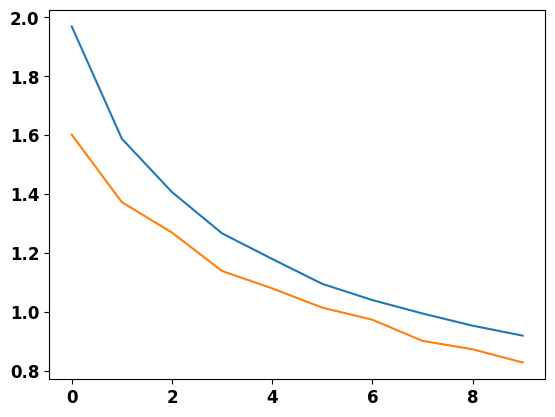

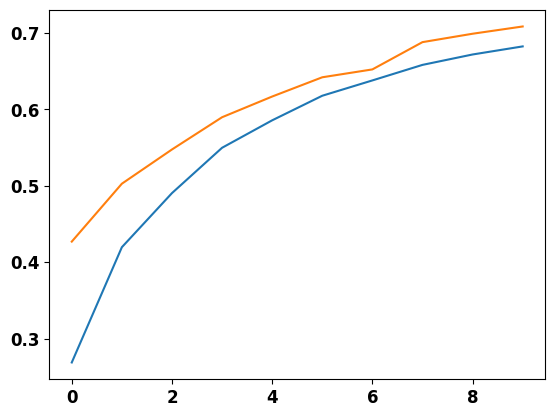

In [81]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [82]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()


313/313 [==============================] - 1s 3ms/step


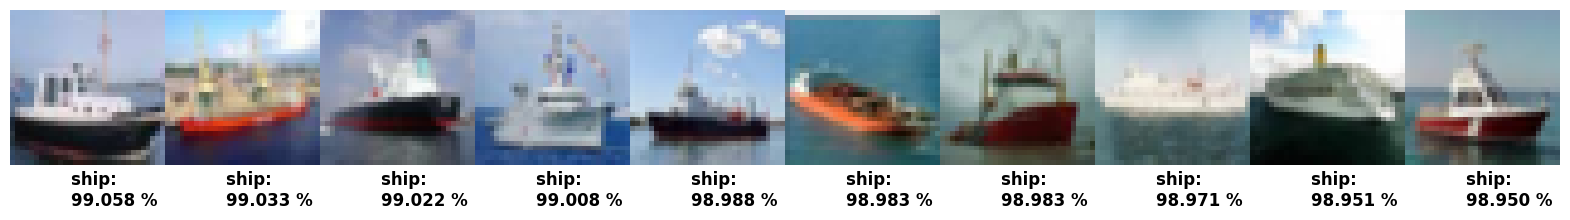

In [83]:
show_the_best_predictions(model, X_test, y_test)

### DESCRIPTIONN ###
firstly i tried to change the hyperparameters. There was a slight iprovement with changing the batch size and numbers of epoch. then i added more hidden layers with different numbers if neurons, but it didnt affected the accuracy that much. Big improvement came with use of different optimizer - ADAM and with adding dropout layers to my model. With these changes i was able to achieve accuracy of about 50%.

Then i googled how other people were making their models, and i tried adding convolution layers with relu activation. this was a game changer. instantly i got accuracy bigger than i achieved so far. I then added another convolution layer and got accuracy of around 70% (with 50 epochs i got 80%).

But i noticed from the graphs, that accuracy and val_accuracy were drifting apart. this signals, that we have overtrained model. i tried adding more dropout layers, but it didnt help very much,  so i added augmentation of training data to battle this. Training of the model takes much more time, but i think from the graphs, that the model isnt overtrained anymore.

output data you see here arent from the latest NN model, because i was put on timeot on this account.